# Imports and Dataset Extraction

In [21]:
import os
import glob
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from google.colab import drive

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/dataset/test.zip'
extract_root = '/content/dataset/test_extract'

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found at: {zip_path}. Please verify the file path or upload the file to Google Drive.")

os.makedirs(extract_root, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

def find_folder(root, name):
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath) == name:
            return dirpath
    return None

images_dir = find_folder(extract_root, 'images')
labels_dir = find_folder(extract_root, 'labels')

if images_dir is None or labels_dir is None:
    raise FileNotFoundError("Could not find 'images' or 'labels' folder after extraction.")

print(f"Images folder: {images_dir}")
print(f"Labels folder: {labels_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images folder: /content/dataset/test_extract/test/images
Labels folder: /content/dataset/test_extract/test/labels


# Test Data Loading and Preprocessing

In [22]:
display_order = [
    'bubbly',
    'transition_bubbly-slug',
    'slug',
    'transition_slug-churn',
    'churn',
    'transition_churn-annular',
    'annular'
]

IMG_HEIGHT, IMG_WIDTH = 598, 96
IMG_CHANNELS = 3

images_path = sorted(glob.glob(os.path.join(images_dir, "*.png")))
labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

X_test = []
y_test = []

for img_path, lbl_path in zip(images_path, labels_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype(np.float32) / 255.0
    X_test.append(img)

    with open(lbl_path, "r") as f:
        first_line = f.readline().strip()
        class_id = int(first_line.split()[0])
        y_test.append(class_id)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

# One-hot encode labels
y_test_categorical = to_categorical(y_test, num_classes=len(display_order))

print(f"Loaded {len(X_test)} test images")

Loaded 415 test images


# TNN Model Loading and Prediction

In [23]:
import gc

# Print TensorFlow version for debugging
print(f"TensorFlow Version: {tf.__version__}")

# Clear any existing models from memory
gc.collect()
tf.keras.backend.clear_session()

print("Cleared existing models from memory")

# necessary components from tensorflow.keras
from tensorflow.keras import layers, models, regularizers

# Exact custom layers as used in training
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        batch = tf.shape(images)[0]
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch, -1, patch_dims])
        return patches

    def compute_output_shape(self, input_shape):
        b, h, w, c = input_shape
        n_h = h // self.patch_size
        n_w = w // self.patch_size
        return (b, n_h * n_w, self.patch_size * self.patch_size * c)

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class ClassTokenPositional(layers.Layer):
    def __init__(self, embed_dim, n_patches, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.n_patches = n_patches

    def build(self, input_shape):
        self.class_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer="zeros",
            trainable=True
        )
        self.pos_embed = self.add_weight(
            shape=(1, self.n_patches + 1, self.embed_dim),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x):
        b = tf.shape(x)[0]
        class_tok = tf.broadcast_to(self.class_token, [b, 1, self.embed_dim])
        x = tf.concat([class_tok, x], axis=1)
        return x + self.pos_embed

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "n_patches": self.n_patches
        })
        return config

print("Custom layers defined (matching training implementation)")
print(f"Test data shapes:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  y_test_categorical: {y_test_categorical.shape}")

# Model path
model_path = '/content/drive/MyDrive/model/tnn_mpfp5.keras'
print(f"Model path: {model_path}")

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

print(f"Model file exists. Size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# Rebuilding the model architecture
print("Attempting to rebuild model architecture...")

try:
    # Constants from training
    IMG_HEIGHT = 598
    IMG_WIDTH = 96
    NUM_CHANNELS = 3
    NUM_CLASSES = 7
    PATCH_SIZE = 16
    EMBED_DIM = 256
    NUM_HEADS = 8
    MLP_DIM = 512
    NUM_ENCODER_LAYERS = 6
    DROPOUT_RATE = 0.2
    L2_WEIGHT_DECAY = 1e-5

    def transformer_encoder_block(x, embed_dim, num_heads, mlp_dim, dropout_rate):
        # Attention block
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(y, y)
        y = layers.Dropout(dropout_rate)(y)
        x = layers.Add()([x, y])

        # MLP block
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(mlp_dim, activation="gelu", kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(y)
        y = layers.Dropout(dropout_rate)(y)
        y = layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(y)
        y = layers.Dropout(dropout_rate)(y)
        x = layers.Add()([x, y])
        return x

    # Build model architecture
    def build_tnn_model():
        inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))

        # Initial processing
        x = layers.Rescaling(1./255)(inputs)
        x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

        # Patch extraction and embedding
        patches = PatchExtract(PATCH_SIZE)(x)
        projected = layers.Dense(EMBED_DIM)(patches)

        # Add positional encoding
        n_patches = projected.shape[1]
        x = ClassTokenPositional(EMBED_DIM, n_patches)(projected)

        # Transformer encoder blocks
        for _ in range(NUM_ENCODER_LAYERS):
            x = transformer_encoder_block(x, EMBED_DIM, NUM_HEADS, MLP_DIM, DROPOUT_RATE)

        # Final classification
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Lambda(lambda t: t[:, 0])(x)  # Take class token
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

        return models.Model(inputs, outputs)

    # Create model architecture
    tnn_model = build_tnn_model()
    print("Model architecture rebuilt successfully")
    print(f"Model input shape: {tnn_model.input_shape}")

    # load weights
    print("Loading model weights...")
    tnn_model.load_weights(model_path)
    print("Model weights loaded successfully!")

except Exception as rebuild_error:
    print(f"Model rebuild failed: {str(rebuild_error)}")

    # Fallback: simple loading with minimal custom objects
    print("Trying simple model loading...")

    try:
        # Disable unsafe deserialization warnings
        import warnings
        warnings.filterwarnings("ignore")

        # Try loading with just the layer names
        custom_objects = {
            'PatchExtract': PatchExtract,
            'ClassTokenPositional': ClassTokenPositional,
        }

        tnn_model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects,
            compile=False
        )
        print("Model loaded with simple approach!")

    except Exception as simple_error:
        print(f"Simple loading also failed: {str(simple_error)}")

        # Try loading without custom objects
        try:
            print("Attempting to load without custom objects (for debugging)...")
            tnn_model = tf.keras.models.load_model(model_path, compile=False)
        except Exception as debug_error:
            print(f"Debug loading error: {str(debug_error)}")

        raise RuntimeError("All model loading approaches failed")

print("Model loaded successfully!")
try:
    print(f"Model input shape: {tnn_model.input_shape}")
    print(f"Model output shape: {tnn_model.output_shape}")
    print(f"Total parameters: {tnn_model.count_params():,}")
except Exception as e:
    print(f"Could not get model info: {e}")

# Test with a small sample
print("\nTesting model with small sample...")
try:
    test_sample = X_test[:1]
    test_pred = tnn_model.predict(test_sample, verbose=0)
    print(f"Test prediction successful! Output shape: {test_pred.shape}")
    print(f"Sample prediction: {test_pred[0]}")
except Exception as test_error:
    print(f"Test prediction failed: {str(test_error)}")
    raise RuntimeError("Model cannot make predictions")

# Make predictions on full dataset
try:
    print("Making predictions on full dataset...")

    # Very small batch size to avoid memory issues
    BATCH_SIZE = 4
    y_pred_probs = tnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
    print(f"Predictions completed! Shape: {y_pred_probs.shape}")

except Exception as pred_error:
    print(f"Full prediction failed: {str(pred_error)}")

    # Try one-by-one prediction
    print("Trying sample-by-sample prediction...")
    try:
        y_pred_probs = []
        for i, sample in enumerate(X_test):
            sample_pred = tnn_model.predict(sample[np.newaxis, ...], verbose=0)
            y_pred_probs.append(sample_pred[0])

            if (i + 1) % 50 == 0:
                print(f"Processed {i+1}/{len(X_test)} samples")

        y_pred_probs = np.array(y_pred_probs)
        print(f"Sample-by-sample prediction completed! Shape: {y_pred_probs.shape}")

    except Exception as sample_error:
        raise RuntimeError(f"Even sample-by-sample prediction failed: {str(sample_error)}")

# label mappings
train_order = ['annular', 'bubbly', 'churn', 'slug', 'transition_bubbly-slug', 'transition_churn-annular', 'transition_slug-churn']
display_order = ['bubbly', 'transition_bubbly-slug', 'slug', 'transition_slug-churn', 'churn', 'transition_churn-annular', 'annular']

# Remap predictions
remap_indices = [train_order.index(c) for c in display_order]
y_pred_probs_remapped = y_pred_probs[:, remap_indices]
y_pred = np.argmax(y_pred_probs_remapped, axis=1)

y_test_remapped = np.array([remap_indices.index(label) for label in y_test])
class_preds = y_pred_probs[:, remap_indices]
y_pred_classes = np.argmax(class_preds, axis=-1)

TensorFlow Version: 2.19.0
Cleared existing models from memory
Custom layers defined (matching training implementation)
Test data shapes:
  X_test: (415, 598, 96, 3)
  y_test: (415,)
  y_test_categorical: (415, 7)
Model path: /content/drive/MyDrive/model/tnn_mpfp5.keras
Model file exists. Size: 133.71 MB
Attempting to rebuild model architecture...
Model architecture rebuilt successfully
Model input shape: (None, 598, 96, 3)
Loading model weights...
Model weights loaded successfully!
Model loaded successfully!
Model input shape: (None, 598, 96, 3)
Model output shape: (None, 7)
Total parameters: 11,649,863

Testing model with small sample...
Test prediction successful! Output shape: (1, 7)
Sample prediction: [0.00501792 0.00836294 0.00189929 0.9614157  0.01379272 0.00287654
 0.00663488]
Making predictions on full dataset...
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step
Predictions completed! Shape: (415, 7)


# TNN Evaluation and Confusion Matrix

Accuracy: 0.8361
Weighted F1 Score: 0.8342

Classification Report:
                           precision    recall  f1-score   support

                  bubbly       0.92      0.92      0.92        60
  transition_bubbly-slug       0.91      0.87      0.89        60
                    slug       0.94      0.97      0.95        60
   transition_slug-churn       0.67      0.77      0.72        56
                   churn       0.59      0.51      0.55        59
transition_churn-annular       0.82      0.82      0.82        60
                 annular       0.98      1.00      0.99        60

                accuracy                           0.84       415
               macro avg       0.83      0.83      0.83       415
            weighted avg       0.83      0.84      0.83       415



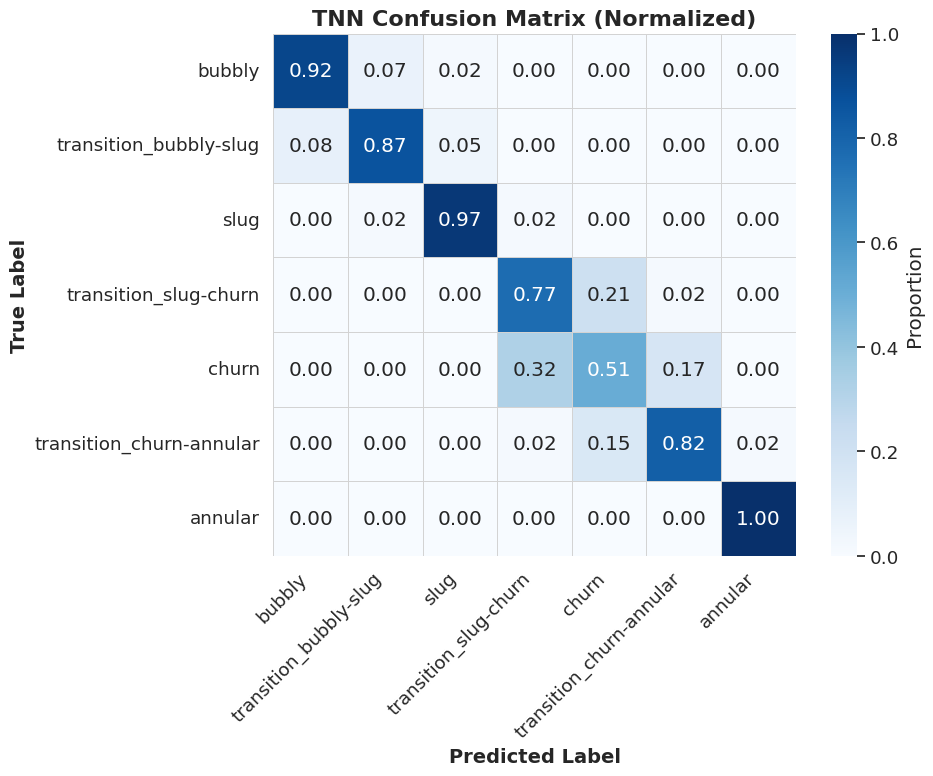

In [24]:

remap_indices = [train_order.index(c) for c in display_order]
y_test_remapped = np.array([np.where(remap_indices == y)[0][0] for y in y_test])

# Accuracy & F1
acc = accuracy_score(y_test_remapped, y_pred_classes)
f1 = f1_score(y_test_remapped, y_pred_classes, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test_remapped, y_pred_classes, target_names=display_order))

# Confusion Matrix
cm = confusion_matrix(y_test_remapped, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set(font_scale=1.2)

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    xticklabels=display_order,
    yticklabels=display_order,
    cbar_kws={'label': 'Proportion'}
)

plt.gca().set_facecolor('white')

plt.title('TNN Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

output_dir = '/content/drive/MyDrive/output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'tnn_confusion_matrix.png'), dpi=300, facecolor='white')
plt.show()

## ROC and AUC

class_preds shape: (415, 7)
y_test_bin shape: (415, 7)
Macro-average AUC: 0.9804


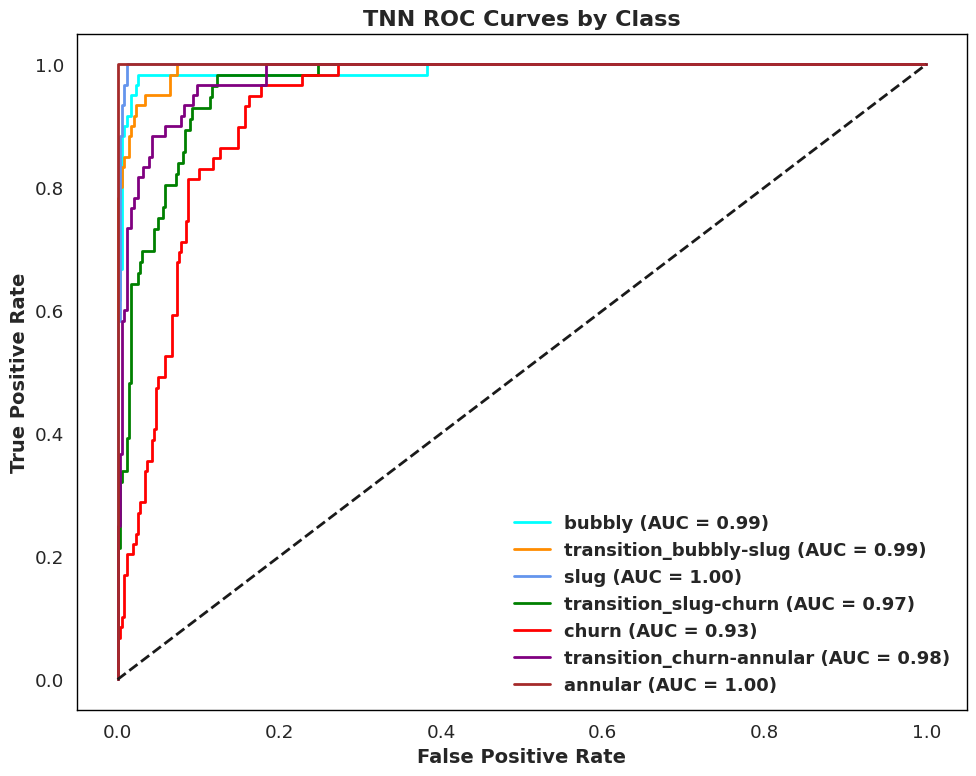

In [25]:
# Binarize the true labels
y_test_bin = label_binarize(y_test_remapped, classes=list(range(len(display_order))))
n_classes = y_test_bin.shape[1]

print("class_preds shape:", class_preds.shape)
print("y_test_bin shape:", y_test_bin.shape)

# Compute ROC curve & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], class_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro-average AUC: {macro_auc:.4f}")

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    ax.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"{display_order[i]} (AUC = {roc_auc[i]:.2f})"
    )

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('TNN ROC Curves by Class', fontsize=16, fontweight='bold')

legend = ax.legend(loc="lower right", fontsize=13, frameon=False)
for text in legend.get_texts():
    text.set_fontweight('bold')

ax.grid(False)

ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'tnn_roc_curves.png'), dpi=300, facecolor='white')
plt.show()

# Example Predictions per Class

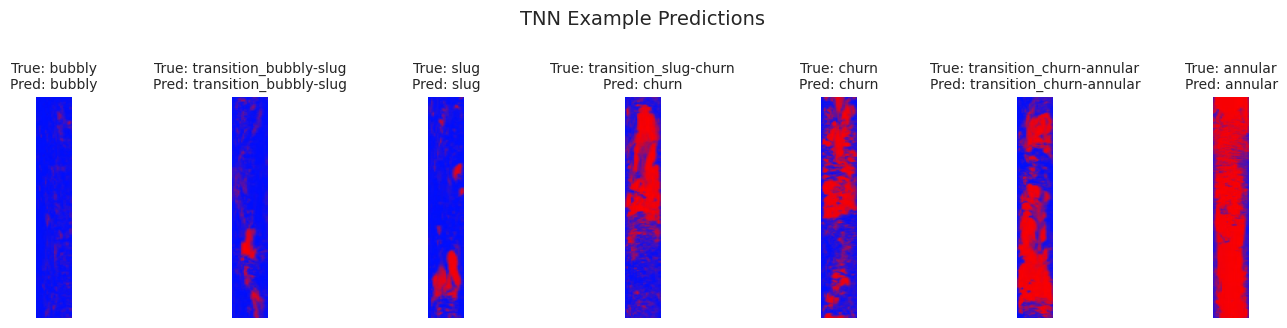

In [26]:
unique_classes = np.unique(y_test_remapped)
fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 3))

for i, class_id in enumerate(unique_classes):
    # Get index of first occurrence of class_id in y_test_remapped
    idx = np.where(y_test_remapped == class_id)[0][0]

    img_path = images_path[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get true and predicted labels
    true_label = display_order[y_test_remapped[idx]]
    pred_label = display_order[y_pred_classes[idx]]

    # Plot
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('TNN Example Predictions', fontsize=14, y=1.1)

plt.savefig(os.path.join(output_dir, 'tnn_example_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

# Attention Map Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


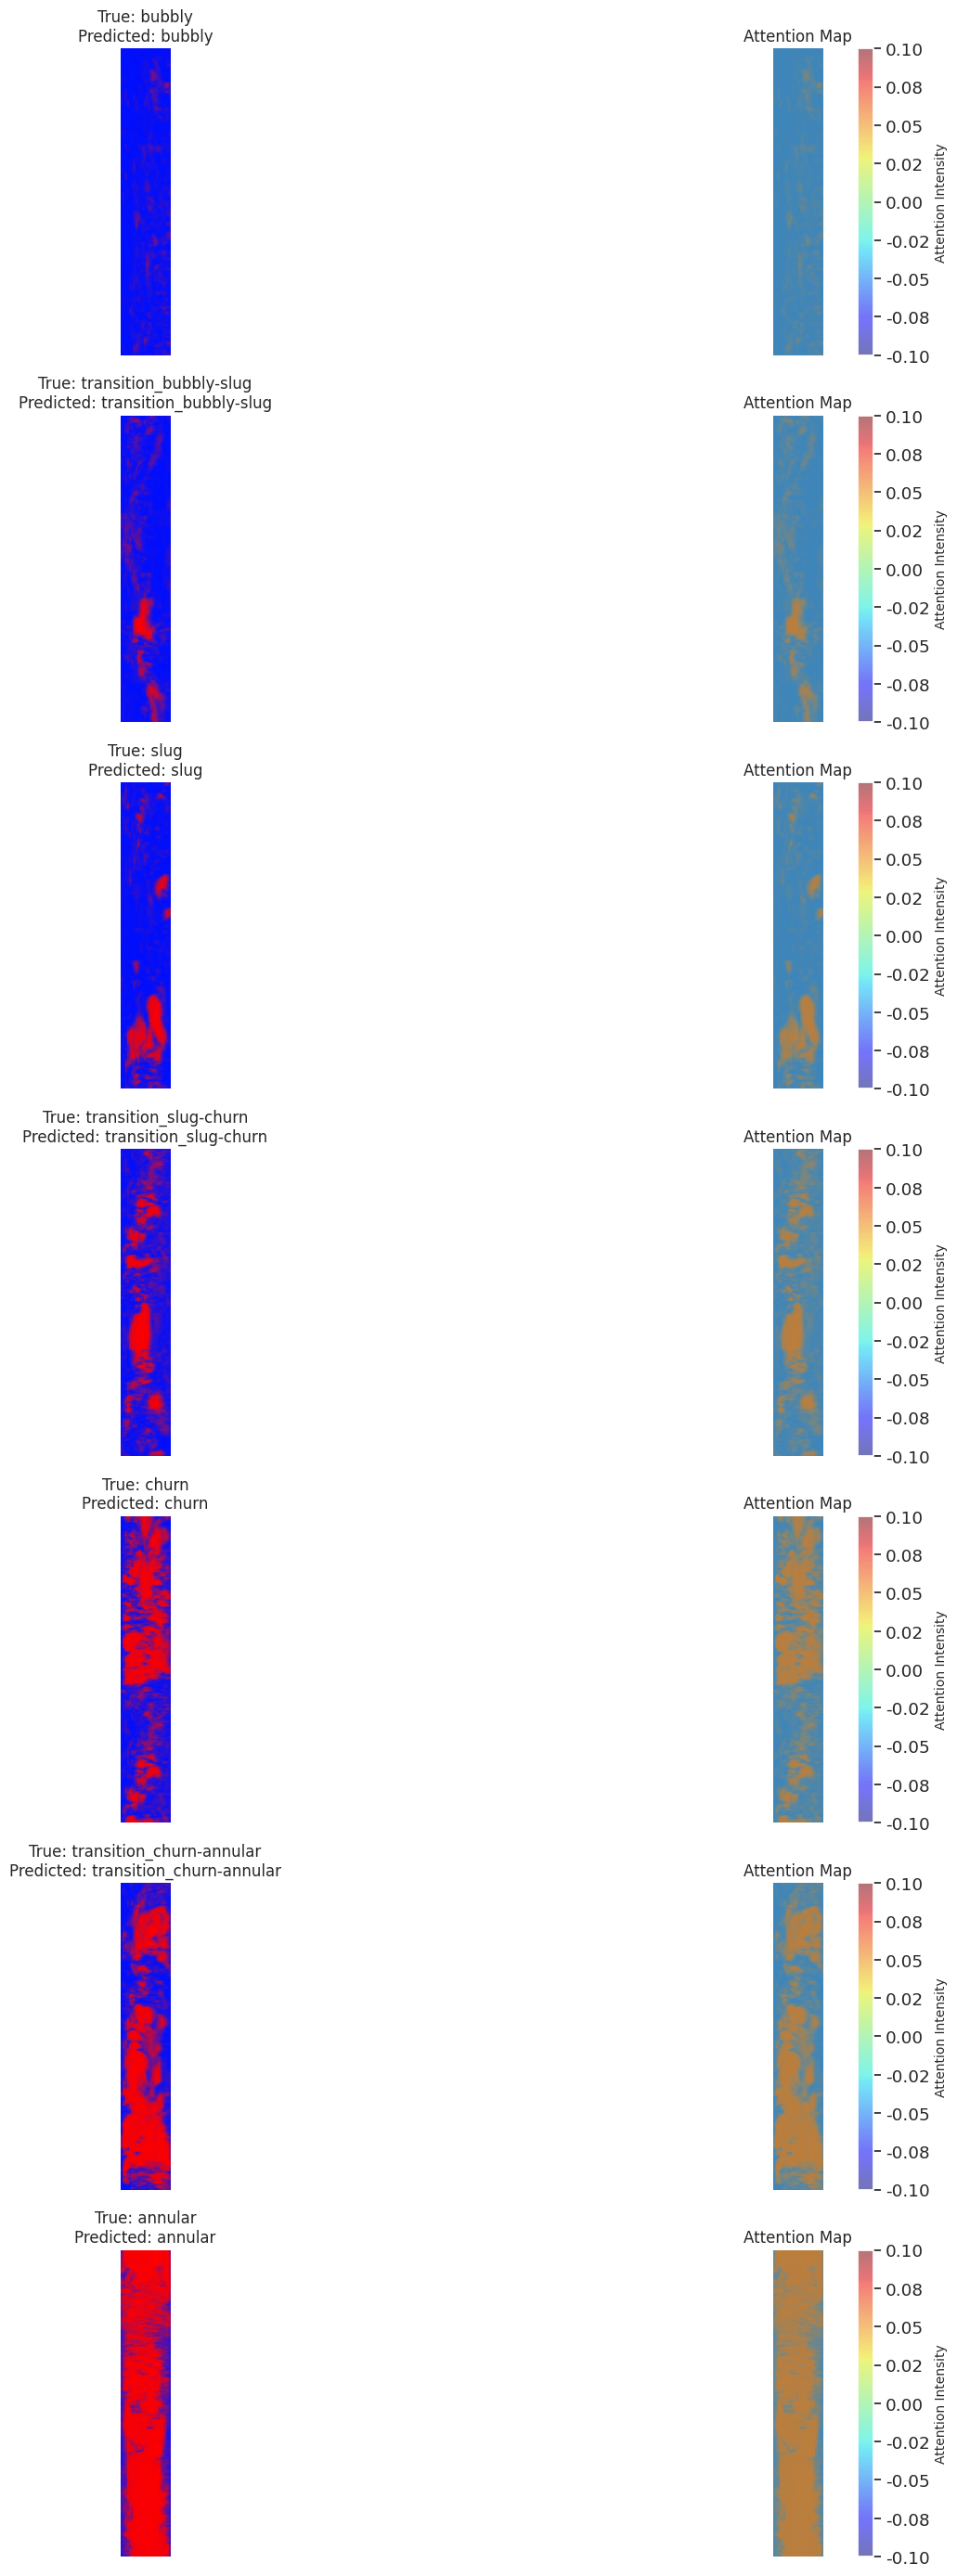

In [28]:
class AttentionMap:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        # Get the attention output from the model
        self.grad_model = Model(inputs=model.inputs,
                                outputs=[model.get_layer(layer_name).output, model.output])

    def generate(self, input_image, class_index):
        attn_output, predictions = self.grad_model(input_image)  # [batch, seq_len, embed_dim]
        token_intensity = tf.reduce_mean(attn_output, axis=-1)   # [batch, seq_len]
        cls_attn = token_intensity[:, 1:]                        # exclude CLS token
        cls_attn = tf.reduce_mean(cls_attn, axis=0)              # average across batch
        cls_attn = tf.maximum(cls_attn, 0)
        attn_max = tf.reduce_max(cls_attn)
        cls_attn = cls_attn / (attn_max + 1e-8) if attn_max > 0 else cls_attn
        return cls_attn.numpy()

# Attention layer
target_layer = 'multi_head_attention_5'
attn_map = AttentionMap(tnn_model, target_layer)

PATCH_SIZE = 16
IMG_HEIGHT, IMG_WIDTH = 598, 96
num_patches = (IMG_HEIGHT // PATCH_SIZE) * (IMG_WIDTH // PATCH_SIZE)

# Find correctly classified samples for each class using the REMAPPED labels
sample_by_class = {}

# Use the remapped labels that match the display_order
for idx, (img, true_label, pred_label) in enumerate(zip(X_test, y_test_remapped, y_pred_classes)):
    if true_label == pred_label and true_label not in sample_by_class:
        sample_by_class[true_label] = img
    if len(sample_by_class) == len(display_order):
        break

# Fill in missing classes with zeros if needed
for class_id in range(len(display_order)):
    if class_id not in sample_by_class:
        sample_by_class[class_id] = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)

# Create visualization
plt.figure(figsize=(14, 4 * len(display_order)))
for i, class_id in enumerate(range(len(display_order))):
    img_np = sample_by_class[class_id]
    img_tensor = np.expand_dims(img_np, axis=0)

    # Generate attention map
    attn_heatmap = attn_map.generate(img_tensor, class_id)

    # Prepare image for display
    img_disp = np.clip(img_np, 0, 1)

    # Get prediction for this image
    pred_probs = tnn_model.predict(img_tensor)
    pred_id = np.argmax(pred_probs, axis=1)[0]

    remap_indices = [train_order.index(c) for c in display_order]
    if pred_id < len(remap_indices):
        pred_display_id = remap_indices.index(pred_id)
    else:
        pred_display_id = pred_id

    # Reshape attention map to match image patches
    if len(attn_heatmap) == num_patches:
        heatmap_grid = attn_heatmap.reshape((IMG_HEIGHT // PATCH_SIZE, IMG_WIDTH // PATCH_SIZE))
        heatmap_resized = cv2.resize(heatmap_grid, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
    else:
        heatmap_resized = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

    heatmap_resized = np.clip(heatmap_resized, 0, 1)

    # Plot original image
    plt.subplot(len(display_order), 2, 2 * i + 1)
    plt.imshow(img_disp)
    plt.title(f"True: {display_order[class_id]}\nPredicted: {display_order[pred_display_id]}", fontsize=12)
    plt.axis("off")

    # Plot attention map overlay
    plt.subplot(len(display_order), 2, 2 * i + 2)
    plt.imshow(img_disp)
    im = plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Attention Map", fontsize=12)
    plt.axis("off")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Intensity', fontsize=10)
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'tnn_attention_maps.png'), dpi=300, facecolor='white')
plt.show()